In [92]:
# Copyright [2024] [KTH Royal Institute of Technology] 
# Licensed under the Educational Community License, Version 2.0 (ECL-2.0)
# This file is part of the Computer Lab 1 for EL2805 - Reinforcement Learning.

import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import random

# Implemented methods
methods = ['DynProg', 'ValIter']

# Some colours
LIGHT_RED    = '#FFC4CC'
LIGHT_GREEN  = '#95FD99'
BLACK        = '#000000'
WHITE        = '#FFFFFF'
LIGHT_PURPLE = '#E8D0FF'

class Maze:

    # Actions
    STAY       = 0
    MOVE_LEFT  = 1
    MOVE_RIGHT = 2
    MOVE_UP    = 3
    MOVE_DOWN  = 4

    # Give names to actions
    actions_names = {
        STAY: "stay",
        MOVE_LEFT: "move left",
        MOVE_RIGHT: "move right",
        MOVE_UP: "move up",
        MOVE_DOWN: "move down"
    }

    # Reward values 
    STEP_REWARD = -1          #TODO
    GOAL_REWARD = 1          #TODO
    IMPOSSIBLE_REWARD = -10   #TODO
    MINOTAUR_REWARD = -10     #TODO

    def __init__(self, maze):
        """ Constructor of the environment Maze.
        """
        self.maze                     = maze
        self.actions                  = self.__actions()
        self.states, self.map         = self.__states()
        self.n_actions                = len(self.actions)
        self.n_states                 = len(self.states)
        self.transition_probabilities = self.__transitions()
        self.rewards                  = self.__rewards()

    def __actions(self):
        actions = dict()
        actions[self.STAY]       = (0, 0)
        actions[self.MOVE_LEFT]  = (0,-1)
        actions[self.MOVE_RIGHT] = (0, 1)
        actions[self.MOVE_UP]    = (-1,0)
        actions[self.MOVE_DOWN]  = (1,0)
        return actions

    def __states(self):
        
        states = dict()
        map = dict()
        s = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                for k in range(self.maze.shape[0]):
                    for l in range(self.maze.shape[1]):
                        if self.maze[i,j] != 1:
                            states[s] = ((i,j), (k,l))
                            map[((i,j), (k,l))] = s
                            s += 1
        
        states[s] = 'Eaten'
        map['Eaten'] = s
        s += 1
        
        states[s] = 'Win'
        map['Win'] = s
        
        return states, map

    def __move(self, state, action):               
        """ Makes a step in the maze, given a current position and an action. 
            If the action STAY or an inadmissible action is used, the player stays in place.
        
            :return list of tuples next_state: Possible states ((x,y), (x',y')) on the maze that the system can transition to.
        """

        if self.states[state] == 'Eaten' or self.states[state] == 'Win': # In these states, the game is over
            return [self.states[state]]
        
        else: # Compute the future possible positions given current (state, action)
            row_player = self.states[state][0][0] + self.actions[action][0] # Row of the player's next position 
            col_player = self.states[state][0][1] + self.actions[action][1] # Column of the player's next position 
            
            # Is the player getting out of the limits of the maze or hitting a wall?
            impossible_action_player = (row_player == -1 or row_player == self.maze.shape[0] or \
                                         col_player == -1 or col_player == self.maze.shape[1] or \
                                         self.maze[row_player, col_player] == 1 ) #TODO
            
            actions_minotaur = [[0, -1], [0, 1], [-1, 0], [1, 0], [0,0]] # Possible moves for the Minotaur
            rows_minotaur, cols_minotaur = [], []
            for i in range(len(actions_minotaur)):
                # Is the minotaur getting out of the limits of the maze?
                impossible_action_minotaur = (self.states[state][1][0] + actions_minotaur[i][0] == -1) or \
                                             (self.states[state][1][0] + actions_minotaur[i][0] == self.maze.shape[0]) or \
                                             (self.states[state][1][1] + actions_minotaur[i][1] == -1) or \
                                             (self.states[state][1][1] + actions_minotaur[i][1] == self.maze.shape[1])
            
                if not impossible_action_minotaur:
                    rows_minotaur.append(self.states[state][1][0] + actions_minotaur[i][0])
                    cols_minotaur.append(self.states[state][1][1] + actions_minotaur[i][1])  
          

            # Based on the impossiblity check return the next possible states.
            if impossible_action_player: # The action is not possible, so the player remains in place
                states = []
                for i in range(len(rows_minotaur)):
                    
                    if (self.states[state][0][0] == rows_minotaur[i] and self.states[state][0][1] == cols_minotaur[i]): # TODO: We met the minotaur
                        states.append('Eaten')
                    
                    elif (self.maze[self.states[state][0][0], self.states[state][0][1]] == 2 ): # TODO: We are at the exit state, without meeting the minotaur
                        states.append('Win')
                
                    else: # The player remains in place, the minotaur moves randomly
                        states.append(((self.states[state][0][0], self.states[state][0][1]), (rows_minotaur[i], cols_minotaur[i])))
                
                return states
          
            else: # The action is possible, the player and the minotaur both move
                states = []
                for i in range(len(rows_minotaur)):
                
                    if (row_player == rows_minotaur[i] and col_player == cols_minotaur[i]): # TODO: We met the minotaur
                        states.append('Eaten')
                    
                    elif self.maze[row_player, col_player] == 2: # TODO:We are at the exit state, without meeting the minotaur
                        states.append('Win')
                    
                    else: # The player moves, the minotaur moves randomly
                        states.append(((row_player, col_player), (rows_minotaur[i], cols_minotaur[i])))
              
                return states
        
        
        

    def __transitions(self):
        """ Computes the transition probabilities for every state action pair.
            :return numpy.tensor transition probabilities: tensor of transition
            probabilities of dimension S*S*A
        """
        # Initialize the transition probailities tensor (S,S,A)
        dimensions = (self.n_states,self.n_states,self.n_actions)
        transition_probabilities = np.zeros(dimensions)

        # TODO: Compute the transition probabilities.
  
        for s in range(self.n_states):
                for a in range(self.n_actions):
                    next_possible_states = self.__move(s,a)
                    prob_next = 1.0/len(next_possible_states)

                    for t in next_possible_states:
                        transition_probabilities[self.map[t],s,a] = prob_next
    
        return transition_probabilities



    def __rewards(self):
        
        """ Computes the rewards for every state action pair """

        rewards = np.zeros((self.n_states, self.n_actions))
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                
                if self.states[s] == 'Eaten': # The player has been eaten
                    rewards[s, a] = self.MINOTAUR_REWARD
                
                elif self.states[s] == 'Win': # The player has won
                    rewards[s, a] = self.GOAL_REWARD
                
                else:                
                    next_states = self.__move(s,a)
                    next_s = next_states[0] # The reward does not depend on the next position of the minotaur, we just consider the first one
                    
                    if self.states[s][0] == next_s[0] and a != self.STAY: # The player hits a wall
                        rewards[s, a] = self.IMPOSSIBLE_REWARD
                    
                    else: # Regular move
                        rewards[s, a] = self.STEP_REWARD

        return rewards




    def simulate(self, start, policy, method):
        
        if method not in methods:
            error = 'ERROR: the argument method must be in {}'.format(methods)
            raise NameError(error)

        path = list()
        
        if method == 'DynProg':
            horizon = policy.shape[1] # Deduce the horizon from the policy shape
            t = 0 # Initialize current time
            s = self.map[start] # Initialize current state 
            path.append(start) # Add the starting position in the maze to the path
            
            while t < horizon - 1:
                a = int(policy[s, t]) # Move to next state given the policy and the current state       
                next_states = self.__move(s, a) # Move to next state given the policy and the current state
                map_next_states = [self.map[state] for state in next_states] # Map the next states
                next_s = np.random.choice(map_next_states, p=self.transition_probabilities[map_next_states, s, a])  # Choose the next state given the transition probabilities
                path.append(self.states[next_s]) # Add the next state to the path
                t +=1 # Update time and state for next iteration
                s = next_s
                
        if method == 'ValIter': 
            t = 1 # Initialize current state, next state and time
            s = self.map[start]
            path.append(start) # Add the starting position in the maze to the path
            next_states = self.__move(s, policy[s]) # Move to next state given the policy and the current state
            map_next_states = [self.map[state] for state in next_states] # Map the next states
            next_s = np.random.choice(map_next_states, p=self.transition_probabilities[map_next_states, s, policy[s]])  # Choose the next state given the transition probabilities
            path.append(self.states[next_s]) # Add the next state to the path
            
            # horizon geometric mean 30
            horizon = np.random.geometric(1/30) # Sample the horizon from a geometric distribution with mean 30
            
            # Loop while state is not the goal state
            while s != next_s and t <= horizon:
                s = next_s # Update state
                next_states = self.__move(s, policy[s]) # Move to next state given the policy and the current state
                map_next_states = [self.map[state] for state in next_states] # Map the next states
                next_s = np.random.choice(map_next_states, p=self.transition_probabilities[map_next_states, s, policy[s]])  # Choose the next state given the transition probabilities
                path.append(self.states[next_s]) # Add the next state to the path
                t += 1 # Update time for next iteration
        
        return [path, horizon] # Return the horizon as well, to plot the histograms for the VI



    def show(self):
        print('The states are :')
        print(self.states)
        print('The actions are:')
        print(self.actions)
        print('The mapping of the states:')
        print(self.map)
        print('The rewards:')
        print(self.rewards)



def dynamic_programming(env, horizon):
    """ Solves the shortest path problem using dynamic programming
        :input Maze env           : The maze environment in which we seek to
                                    find the shortest path.
        :input int horizon        : The time T up to which we solve the problem.
        :return numpy.array V     : Optimal values for every state at every
                                    time, dimension S*T
        :return numpy.array policy: Optimal time-varying policy at every state,
                                    dimension S*T
    """
    #TODO

    ### MDP
    P         = env.transition_probabilities
    r         = env.rewards
    n_states  = env.n_states
    n_actions = env.n_actions
    T         = horizon

    ### objectives to compute
    V = np.zeros((env.n_states, horizon+1))
    policy = np.zeros((env.n_states, horizon+1))

    #initialization
    V[env.map['Win'], -1] = 1
    V[env.map['Eaten'], -1] = -100

    for t in range(T-1, -1, -1):
        # Compute Q-values for all states and actions simultaneously
        Q = r + np.matmul(P.transpose(1, 2, 0), V[:, t+1])
        
        # Update value function by taking the maximum Q-value for each state
        V[:, t] = np.max(Q, axis=1)
        
        # Update policy by selecting the action corresponding to the maximum Q-value
        policy[:, t] = np.argmax(Q, axis=1)

    return V, policy

def value_iteration(env, gamma, epsilon):
    """ Solves the shortest path problem using value iteration
        :input Maze env           : The maze environment in which we seek to
                                    find the shortest path.
        :input float gamma        : The discount factor.
        :input float epsilon      : accuracy of the value iteration procedure.
        :return numpy.array V     : Optimal values for every state at every
                                    time, dimension S*T
        :return numpy.array policy: Optimal time-varying policy at every state,
                                    dimension S*T
    """

    P = env.transition_probabilities  # Shape: (n_states, n_states, n_actions)
    r = env.rewards                   # Shape: (n_states, n_actions)
    n_states = env.n_states
    n_actions = env.n_actions

    V = np.zeros(n_states)  # Initialize value function
    policy = np.zeros(n_states, dtype=int)  # Initialize policy

    tolerance_thr = epsilon * (1 - gamma) / gamma
    delta = tolerance_thr + 1  # Force at least one iteration

    while delta > tolerance_thr:
        Q = np.zeros((n_states, n_actions))  # Store Q-values for all states and actions

        # Compute Q-values for each action in each state
        for s in range(n_states):
            for a in range(n_actions):
                Q[s, a] = r[s, a] + gamma * np.dot(P[:, s, a], V)

        # Get the best value and action for each state
        V_next = np.max(Q, axis=1)

        # Update convergence criterion
        delta = np.max(np.abs(V_next - V))
        V = V_next
    
    policy = np.argmax(Q, axis=1)

    return V, policy

In [118]:
def static_solution_with_arrows_numbers(maze, path):
    """
    Generates a static visualization of the maze with arrows showing the path of the person and the Minotaur,
    including numbers to indicate the timestep of each movement.

    Args:
        maze (np.array): 2D array representing the maze.
        path (list): List of tuples representing the sequence of positions for the person and the Minotaur.
                     Each element is a tuple ((person_row, person_col), (minotaur_row, minotaur_col)).
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Map a color to each cell in the maze
    col_map = {0: "white", 1: "black", 2: "lightgreen", -1: "lightcoral", -2: "plum", 3: "bisque"}
    
    rows, cols = maze.shape
    fig, ax = plt.subplots(figsize=(cols, rows))

    # Draw the maze
    for r in range(rows):
        for c in range(cols):
            cell_color = col_map[maze[r, c]]
            ax.add_patch(patches.Rectangle((c, r), 1, 1, facecolor=cell_color, edgecolor="gray"))

    # Add arrows and numbers for the person's and Minotaur's paths
    for i in range(1, len(path)):
        # Extract positions of person and Minotaur
        person_start = path[i - 1][0]
        minotaur_start = path[i - 1][1]
        person_end = path[i][0]
        minotaur_end = path[i][1]

        # Draw arrow for the person's movement
        ax.arrow(
            person_start[1] + 0.5, person_start[0] + 0.5,
            person_end[1] - person_start[1], person_end[0] - person_start[0],
            head_width=0.2, head_length=0.2, fc="blue", ec="blue", linewidth=1
        )
        # Add timestep number for the person's movement
        mid_x = (person_start[1] + person_end[1]) / 2 + 0.5
        mid_y = (person_start[0] + person_end[0]) / 2 + 0.5
        ax.text(mid_x, mid_y, str(i), color="blue", fontsize=8, ha="center", va="center")

        # Draw arrow for the Minotaur's movement
        ax.arrow(
            minotaur_start[1] + 0.5, minotaur_start[0] + 0.5,
            minotaur_end[1] - minotaur_start[1], minotaur_end[0] - minotaur_start[0],
            head_width=0.2, head_length=0.2, fc="red", ec="red", linewidth=1
        )
        # Add timestep number for the Minotaur's movement
        mid_x = (minotaur_start[1] + minotaur_end[1]) / 2 + 0.5
        mid_y = (minotaur_start[0] + minotaur_end[0]) / 2 + 0.5
        ax.text(mid_x, mid_y, str(i), color="red", fontsize=8, ha="center", va="center")

    # Adjust the aspect ratio
    ax.set_aspect("equal")
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.gca().invert_yaxis()

    # Display the static solution
    plt.title("Movement of the person following the optimal policy")
    plt.show()


In [116]:
def static_solution_with_arrows(maze, path):
    """
    Generates a static visualization of the maze with arrows showing the path of the person and the Minotaur.

    Args:
        maze (np.array): 2D array representing the maze.
        path (list): List of tuples representing the sequence of positions for the person and the Minotaur.
                     Each element is a tuple ((person_row, person_col), (minotaur_row, minotaur_col)).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Map a color to each cell in the maze
    col_map = {0: "white", 1: "black", 2: "lightgreen", -1: "lightcoral", -2: "lightpurple", 3: "bisque"}
    
    rows, cols = maze.shape
    fig, ax = plt.subplots(figsize=(cols, rows))

    # Flip the maze vertically for correct visualization
    flipped_maze = np.flipud(maze)

    # Draw the maze
    for r in range(rows):
        for c in range(cols):
            cell_color = col_map[flipped_maze[r, c]]
            ax.add_patch(patches.Rectangle((c, r), 1, 1, facecolor=cell_color, edgecolor="gray"))

    # Add arrows for the person's and Minotaur's paths
    for i in range(1, 15):
        # Extract positions of person and Minotaur
        person_start = path[i - 1][0]
        minotaur_start = path[i - 1][1]
        person_end = path[i][0]
        minotaur_end = path[i][1]

        # Adjust row coordinates to match flipped maze
        person_start = (rows - 1 - person_start[0], person_start[1])
        minotaur_start = (rows - 1 - minotaur_start[0], minotaur_start[1])
        person_end = (rows - 1 - person_end[0], person_end[1])
        minotaur_end = (rows - 1 - minotaur_end[0], minotaur_end[1])

        # Draw arrow for the person's movement
        ax.arrow(
            person_start[1] + 0.5, person_start[0] + 0.5,
            person_end[1] - person_start[1], person_end[0] - person_start[0],
            head_width=0.2, head_length=0.2, fc="blue", ec="blue", linewidth=1
        )

        # Draw arrow for the Minotaur's movement
        #ax.arrow(
        #    minotaur_start[1] + 0.5, minotaur_start[0] + 0.5,
        #    minotaur_end[1] - minotaur_start[1], minotaur_end[0] - minotaur_start[0],
        #    head_width=0.2, head_length=0.2, fc="red", ec="red", linewidth=1
        #)
    ax.arrow(
            6 + 0.5, 0.5,
            -1, 0,
            head_width=0.2, head_length=0.2, fc="blue", ec="blue", linewidth=1
    )
    # Adjust the aspect ratio
    ax.set_aspect("equal")
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #plt.gca().invert_yaxis()

    # Display the static solution
    plt.title("Static Solution with Arrows")
    plt.show()


In [110]:
def animate_solution(maze, path):

    # Map a color to each cell in the maze
    col_map = {0: WHITE, 1: BLACK, 2: LIGHT_GREEN, -1: LIGHT_RED, -2: LIGHT_PURPLE}
    
    rows, cols = maze.shape # Size of the maze
    fig = plt.figure(1, figsize=(cols, rows)) # Create figure of the size of the maze

    # Remove the axis ticks and add title
    ax = plt.gca()
    ax.set_title('Policy simulation')
    ax.set_xticks([])
    ax.set_yticks([])

    # Give a color to each cell
    colored_maze = [[col_map[maze[j, i]] for i in range(cols)] for j in range(rows)]

    # Create a table to color
    grid = plt.table(
        cellText = None, 
        cellColours = colored_maze, 
        cellLoc = 'center', 
        loc = (0,0), 
        edges = 'closed'
    )
    
    # Modify the height and width of the cells in the table
    tc = grid.properties()['children']
    for cell in tc:
        cell.set_height(1.0/rows)
        cell.set_width(1.0/cols)

    for i in range(0, len(path)):
        if path[i-1] != 'Eaten' and path[i-1] != 'Win':
            grid.get_celld()[(path[i-1][0])].set_facecolor(col_map[maze[path[i-1][0]]])
            grid.get_celld()[(path[i-1][1])].set_facecolor(col_map[maze[path[i-1][1]]])
        if path[i] != 'Eaten' and path[i] != 'Win':
            grid.get_celld()[(path[i][0])].set_facecolor(col_map[-2]) # Position of the player
            grid.get_celld()[(path[i][1])].set_facecolor(col_map[-1]) # Position of the minotaur
        display.display(fig)
        time.sleep(1)
        display.clear_output(wait = True)

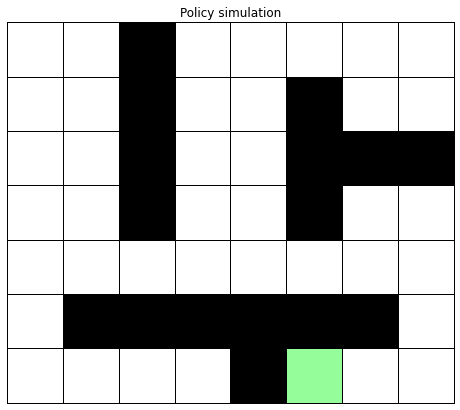

KeyboardInterrupt: 

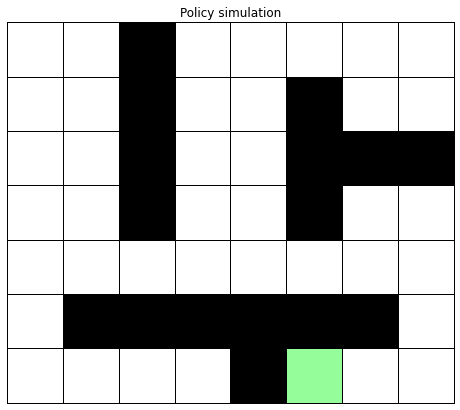

In [96]:
if __name__ == "__main__":
    # Description of the maze as a numpy array
    maze = np.array([
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 2, 0, 0]])
    # With the convention 0 = empty cell, 1 = obstacle, 2 = exit of the Maze
    
    env = Maze(maze) # Create an environment maze

    # Solve the MDP problem with dynamic programming
    V, policy = dynamic_programming(env, horizon)  


    method = 'DynProg'
    start  = ((0,0), (6,5))
    path = env.simulate(start, policy, method)[0]



    animate_solution(maze, path)

    static_solution_with_arrows_numbers(maze, path)

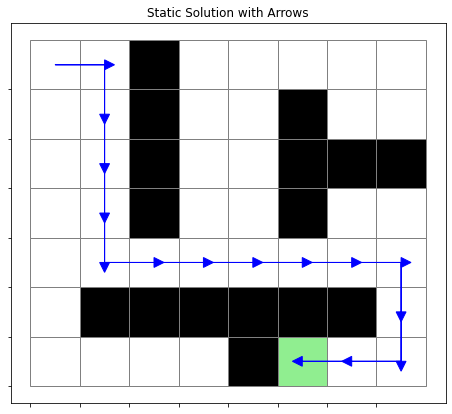

In [119]:
static_solution_with_arrows(maze, path)


In [120]:
if __name__ == "__main__":
    # Description of the maze as a numpy array
    maze = np.array([
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 1, 2, 0, 0]])
    # With the convention 0 = empty cell, 1 = obstacle, 2 = exit of the Maze
    
    env = Maze(maze) # Create an environment maze

    n_alive_stay = [0 for i in range(31)]
    
    for horizon in range(15,31):

        # Solve the MDP problem with dynamic programming
        V, policy = dynamic_programming(env, horizon)  


        for sim in range(10000):
            # Simulate the shortest path starting from position A
            method = 'DynProg'
            start  = ((0,0), (6,5))
            path = env.simulate(start, policy, method)[0]

            if path[-1] == 'Win':
                n_alive_stay[horizon]+=1


    #animate_solution(maze, path)

In [70]:
for i in range(len(n_alive_stay)):
    print(i,' : ', n_alive_stay[i])

0  :  0
1  :  0
2  :  0
3  :  0
4  :  0
5  :  0
6  :  0
7  :  0
8  :  0
9  :  0
10  :  0
11  :  0
12  :  0
13  :  0
14  :  0
15  :  2757
16  :  4281
17  :  5284
18  :  5884
19  :  6635
20  :  7187
21  :  7606
22  :  8054
23  :  8336
24  :  8552
25  :  8790
26  :  8992
27  :  9161
28  :  9291
29  :  9397
30  :  9469


In [42]:
len(n_alive_stay)

31

In [21]:
for i in range(31):
    print(i, n_alive[i])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 831
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0


In [4]:
print('The path is:', path)

The path is: [((0, 0), (6, 5)), ((0, 1), (5, 5)), ((1, 1), (4, 5)), ((2, 1), (4, 4)), ((3, 1), (5, 4)), ((4, 1), (5, 5)), ((4, 2), (6, 5)), ((4, 3), (6, 6)), ((4, 4), (6, 5)), ((4, 5), (6, 6)), ((4, 6), (5, 6)), ((4, 7), (6, 6)), ((5, 7), (5, 6)), ((6, 7), (6, 6)), ((6, 6), (5, 6)), 'Win', 'Win', 'Win', 'Win', 'Win', 'Win']


In [9]:
path

[((0, 0), (6, 5)),
 ((0, 0), (6, 6)),
 ((0, 0), (5, 6)),
 ((0, 0), (6, 6)),
 ((0, 0), (6, 7)),
 ((0, 0), (5, 7))]

In [12]:
env = Maze(maze)
start  = ((0,0), (6,5))
path = env.simulate(start, policy, method)[0]



In [14]:
path


[((0, 0), (6, 5)),
 ((0, 0), (6, 4)),
 ((0, 0), (5, 4)),
 ((0, 0), (6, 4)),
 ((0, 0), (6, 3)),
 ((0, 0), (5, 3))]

### plotting

In [29]:
n_alive_no_stay = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]

n_alive_stay = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,291,428,527,584,668,722,775,805,843,858, 863,922,906,926,945,948]

In [121]:
n_alive = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]

prob_no_stay = [n_aliv/1000 for n_aliv in n_alive]
prob_stay = [n_aliv/10000 for n_aliv in n_alive_stay]

In [122]:
len(prob_no_stay)

31

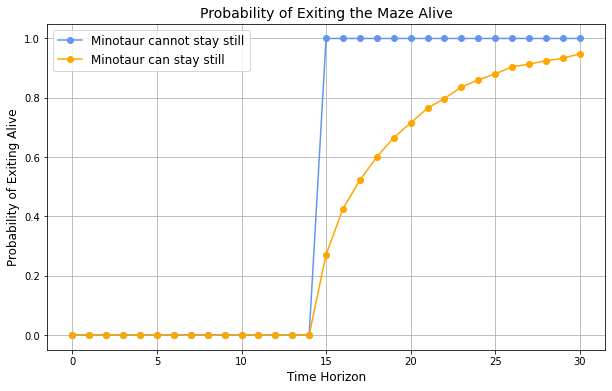

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for the two cases
time_horizon = np.arange(0, 31)  # Time horizon from 1 to 30

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time_horizon, prob_no_stay, marker='o', label='Minotaur cannot stay still', linestyle='-', color='cornflowerblue')
plt.plot(time_horizon, prob_stay, marker='o', label='Minotaur can stay still', linestyle='-', color='orange')

# Add labels, title, and legend
plt.title('Probability of Exiting the Maze Alive', fontsize=14)
plt.xlabel('Time Horizon', fontsize=12)
plt.ylabel('Probability of Exiting Alive', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()